# TIGER

## Download data

In [1]:
!aws s3 ls --no-sign-request s3://tiger-training/

                           PRE wsibulk/
                           PRE wsirois/
                           PRE wsitils/
2022-01-14 14:00:17       2186 data-structure.txt
2022-01-17 13:25:37        578 license.txt


In [11]:
!aws s3 cp --no-sign-request s3://tiger-training/wsirois/wsi-level-annotations/images/100B.tif ./tiger_data/images

download: s3://tiger-training/wsirois/wsi-level-annotations/images/100B.tif to tiger_data/images/100B.tif


In [14]:
!aws s3 cp --no-sign-request s3://tiger-training/wsirois/wsi-level-annotations/annotations-tissue-cells-xmls/100B.xml ./tiger_data/annotations

download: s3://tiger-training/wsirois/wsi-level-annotations/annotations-tissue-cells-xmls/100B.xml to tiger_data/annotations/100B.xml


## Setup

In [7]:
from wholeslidedata import WholeSlideImage, WholeSlideAnnotation
from wholeslidedata.interoperability.asap.backend import AsapWholeSlideImageBackend
from wholeslidedata.visualization.plotting import plot_patch, plot_annotations
from matplotlib import pyplot as plt
import numpy as np
import cv2
from colour import Color


def plot_coordinates(image, coordinates, border_rgb, thickness=1, fill_rgb=None, alpha=1):
    overlay = image.copy()
    overlay = cv2.polylines(overlay, [np.int32(coordinates)], True, color=border_rgb, thickness=thickness)
    if fill_rgb is not None:
        overlay = cv2.fillPoly(overlay,  [np.int32(coordinates)], color=fill_rgb)
    return cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)
    

def plot_annotations2(image, annotations, offset, color_map, boxes=False, ratio=4, fill=False):
    for annotation in annotations:
        rgb_color = color_map[annotation.label.name]
        coordinates = (annotation.coordinates -np.array(offset)) /ratio
        if fill:
            image = plot_coordinates(image, coordinates, border_rgb=rgb_color, fill_rgb=rgb_color)
        else:
            image = plot_coordinates(image, coordinates, border_rgb=rgb_color)
    return image


TIGER_COLORS = {
    "roi": "#000000",
    "lymphocytes and plasma cells": "#000000",
    "invasive tumor":  '#00e0f9',
    "tumor-associated stroma": '#00f932' ,
    "in-situ tumor": '#aef900' ,
    "healthy glands":  '#f96400',
    "necrosis not in-situ": '#f9007d' ,
    "inflamed stroma":  '#9500f9',
    "rest":  '#0000ce',
}
TIGER_COLORS_RGB = {name: tuple((int(255*c) for c in Color(color).rgb)) for name, color in tiger_colors.items()}

In [8]:
wsi = WholeSlideImage('./tiger_data/images/100B.tif', backend=AsapWholeSlideImageBackend)
wsa = WholeSlideAnnotation('./tiger_data/annotations/100B.xml', sample_label_names=['roi'])
colors = {label.name: tiger_colors[label.name] for label in wsa.labels}

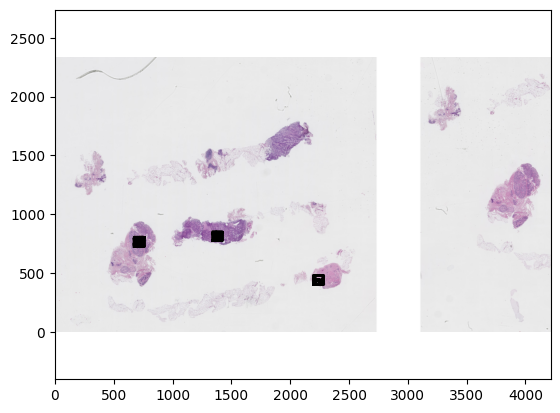

In [9]:
fig, ax  = plt.subplots()
plot_patch(wsi.get_slide(8.0), ax=ax)
plot_annotations(wsa.annotations, ax=ax, scale=1/16)
plt.gca().invert_yaxis()
plt.show()

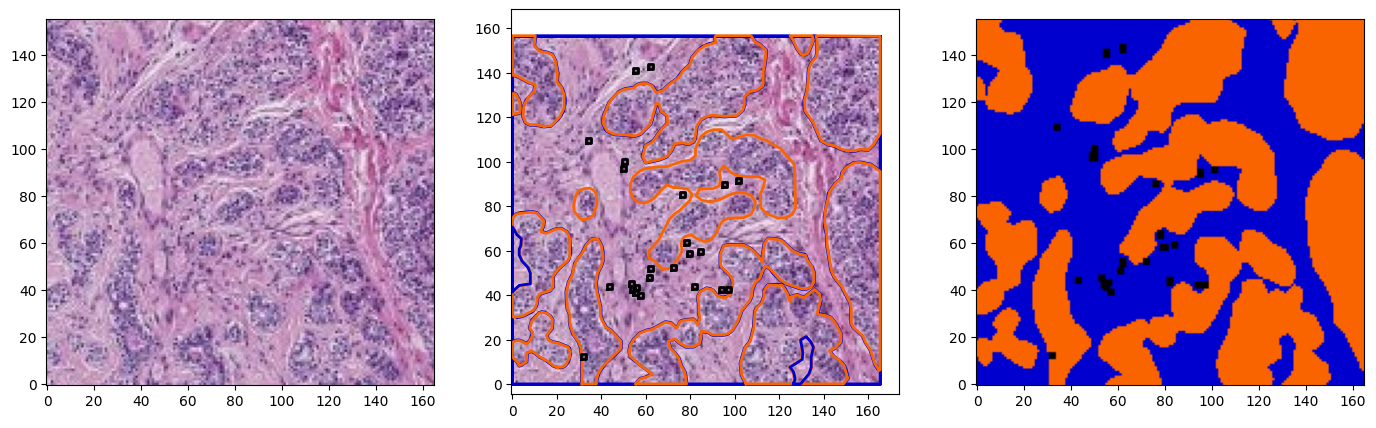

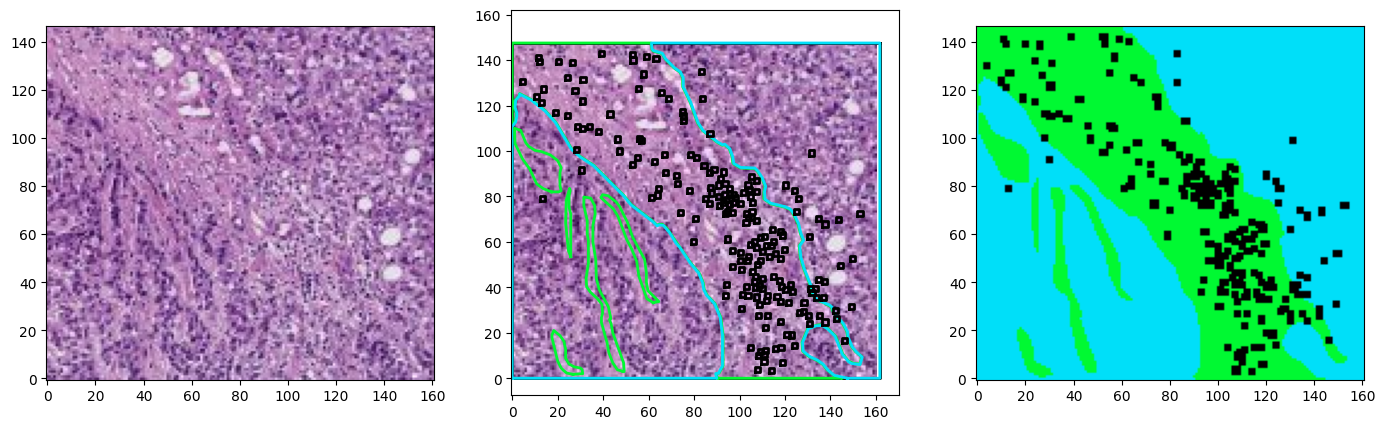

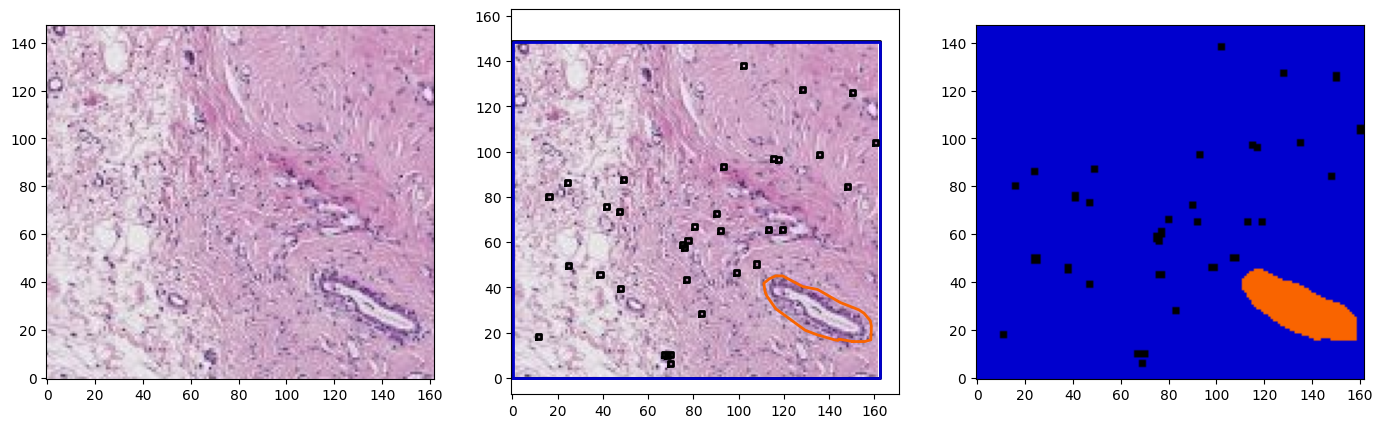

In [10]:
for idx in range(3):
    region = wsi.get_region_from_annotations([wsa.sampling_annotations[idx]], spacing=4.0)
    annotations = wsa.select_annotations(*wsa.sampling_annotations[idx].center, *wsa.sampling_annotations[idx].size)
    annotations = sorted(annotations, key=lambda x: x.area, reverse=True)
    offset = wsa.sampling_annotations[idx].bounds[:2]
    annotations_on_image = plot_annotations2(region, annotations, offset=offset,  ratio=8, color_map=TIGER_COLORS_RGB,fill=True)
    fig, ax = plt.subplots(1,3, figsize=(17,5))
    plot_patch(region, ax=ax[0])
    plot_patch(region, ax=ax[1])
    plot_annotations(annotations, ax=ax[1], scale=1/8, use_base_coordinates=True, color_map=colors)
    plot_patch(annotations_on_image, ax=ax[2])
    
    for a in ax:
        a.invert_yaxis()
    plt.show()

## Data Loading - Batch Iterator

In [1]:
from wholeslidedata.iterators import create_batch_iterator
from wholeslidedata.visualization.plotting import plot_batch
import time

In [2]:
user_config = {
    'wholeslidedata': {
        'default': {
            'yaml_source': "/home/user/pathology-whole-slide-data/docs/source/userguide/notebooks/examples/configs/tigersegmentationdata.yml",
            'labels': {
                "roi": 0,
                "invasive tumor": 1,
                "tumor-associated stroma": 2,
                "in-situ tumor": 3 ,
                "healthy glands": 4,
                "necrosis not in-situ": 5,
                "inflamed stroma": 6,
                "rest": 7,
            },
            
            "annotation_parser": {
                "sample_label_names": ['roi']
            },
            'batch_shape': {
                'batch_size': 10,
                'spacing': 0.5,
                'shape': [512,512,3],
            },
            'point_sampler_name': "RandomPointSampler",
            'point_sampler': {
                "buffer": {'spacing': "${batch_shape.spacing}", 'value': -256},
            }
        }
    }
}

In [3]:
t1 = time.time()
tiger_batch_iterator = create_batch_iterator(mode="training", user_config=user_config, cpus=4)
print(time.time()-t1)

88.77838516235352


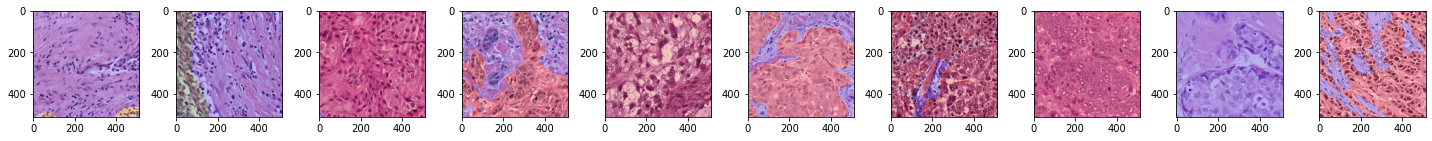

In [5]:
x_batch, y_batch, info =  next(tiger_batch_iterator)
plot_batch(x_batch, y_batch, alpha=0.2)